<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/Two_finger_neural_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules

In [ ]:
# Copy custom modules to current working directory for import
!cp /content/drive/MyDrive/'Colab Notebooks'/neural_decoders.py /content
!cp /content/drive/MyDrive/'Colab Notebooks'/utils.py /content


In [ ]:
# Import modules
# from neural_decoders import *
# from utils import *

# Force reload of the updated module
import importlib
import neural_decoders
import utils
importlib.reload(neural_decoders)
importlib.reload(utils)


<module 'utils' from '/content/utils.py'>

### Load Data

---



In [ ]:
# Mar 14.25.F
from scipy.io import loadmat

file_name = 'MonkeyN_KC' # MonkeyN_KC, MonkeyN_RC, MonkeyW_KC, MonkeyW_RC
file_path = f'/content/drive/MyDrive/ML Projects/Two Finger Neural Decoding/Data/{file_name}.mat'

mat_data = loadmat(file_path)
targ     = mat_data['targ']  # num_bins x 2 (for two fingers)
targsize = mat_data['targsize']
neural_data = mat_data['X'] # num_bins x num_channels
trials = mat_data['trials']
targ_feedback = mat_data['y'] # predicted positions and associated velocities from the Kalman filter algorithm in use, prior to ReFIT manipulations. [T x 4]: [pos_1, pos_2, vel_1, vel_2]


In [ ]:
targ_feedback.shape

(14459, 4)

In [ ]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'targsize', 'X', 'targ', 'trials', 'y'])

In [ ]:
print(f"Neural data shape: {neural_data.shape}")
print(f"Kinematic targets shape: {targ.shape}")


Neural data shape: (14459, 96)
Kinematic targets shape: (14459, 2)


In [ ]:
from scipy.io import loadmat
import numpy as np

mat_data = loadmat('trialmats_speech_AIP.mat')


In [ ]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'overtOrcovert', 'trialmataip', 'trialmataip_artreject', 'wordIndex'])

In [ ]:
neural_data       = mat_data['trialmataip'] #
grasp_type        = mat_data['overtOrcovert']  #
# hand_open_close   = mat_data['handOpenOrClose']

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

def time_varying_decoder(neural_data, grasp_type, window_size=5, mode='flatten',
                         model='svm', **model_kwargs):
    """
    Time-varying neural decoder using a sliding window and specified classifier.

    Parameters:
    - neural_data: N x T x R array (N: electrodes, T: time bins, R: trials)
    - grasp_type: 1 x R array of labels
    - window_size: sliding window size (in time bins)
    - mode: 'flatten' (N * window_size) or 'mean' (N)
    - model: one of ['svm', 'nb', 'tree', 'knn']
    - model_kwargs: extra keyword arguments passed to the classifier

    Returns:
    - time_points: list of center time bins for each window
    - decoding_accuracy: list of cross-validated decoding accuracies
    """
    N, T, R = neural_data.shape
    grasp_type = np.array(grasp_type).flatten()

    time_points = []
    decoding_accuracy = []

    t_range = range(window_size // 2, T - window_size // 2)

    print(f"Starting decoding (mode = '{mode}', model = '{model}')...")
    for t in tqdm(t_range, desc="Decoding Progress"):
        # Extract neural window: N x window_size x R
        window_data = neural_data[:, t - window_size // 2 : t + window_size // 2 + 1, :]

        if mode == 'flatten':
            X = window_data.reshape(N * window_size, R).T  # R x (N * window_size)
        elif mode == 'mean':
            X = window_data.mean(axis=1).T  # R x N
        else:
            raise ValueError("mode must be 'flatten' or 'mean'")

        y = grasp_type

        # Select classifier
        if model == 'svm':
            clf = SVC(**model_kwargs)
        elif model == 'nb':
            clf = GaussianNB(**model_kwargs)
        elif model == 'tree':
            clf = DecisionTreeClassifier(**model_kwargs)
        elif model == 'knn':
            clf = KNeighborsClassifier(**model_kwargs)
        else:
            raise ValueError("model must be one of: 'svm', 'nb', 'tree', 'knn'")

        # Cross-validated accuracy
        acc = cross_val_score(clf, X, y, cv=5).mean()

        time_points.append(t)
        decoding_accuracy.append(acc)

    print("Decoding complete.")
    return time_points, decoding_accuracy


Starting decoding (mode = 'flatten', model = 'svm')...


Decoding Progress: 100%|██████████| 233/233 [00:07<00:00, 31.53it/s]


Decoding complete.


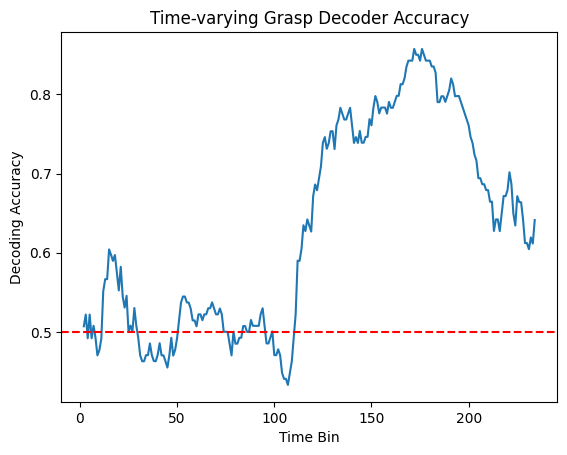

In [ ]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='svm', kernel='rbf')

import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.axhline(y=0.5, color='r', linestyle='--', label=f'Chance Level')

plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Starting decoding (mode = 'flatten', model = 'svm')...


Decoding Progress: 100%|██████████| 233/233 [00:18<00:00, 12.68it/s]


Decoding complete.


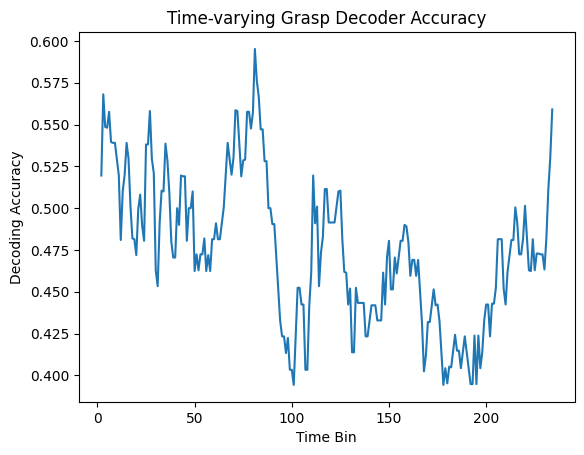

In [ ]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='svm', kernel='rbf')

import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Starting decoding (mode = 'flatten', model = 'knn')...


Decoding Progress: 100%|██████████| 233/233 [00:06<00:00, 34.67it/s]


Decoding complete.


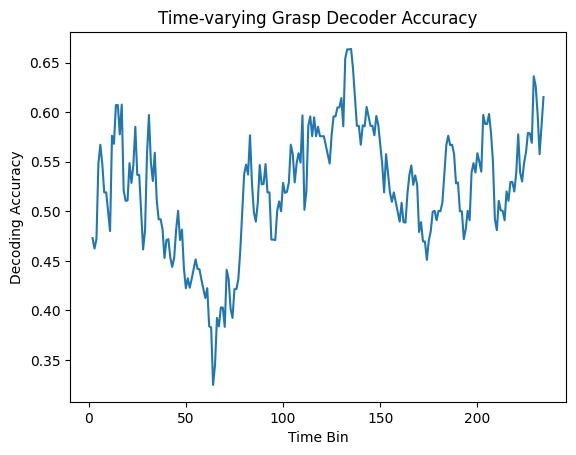

In [ ]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='knn', n_neighbors=3)

import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Starting decoding (mode = 'flatten', model = 'nb')...


Decoding Progress: 100%|██████████| 233/233 [00:04<00:00, 55.84it/s]


Decoding complete.


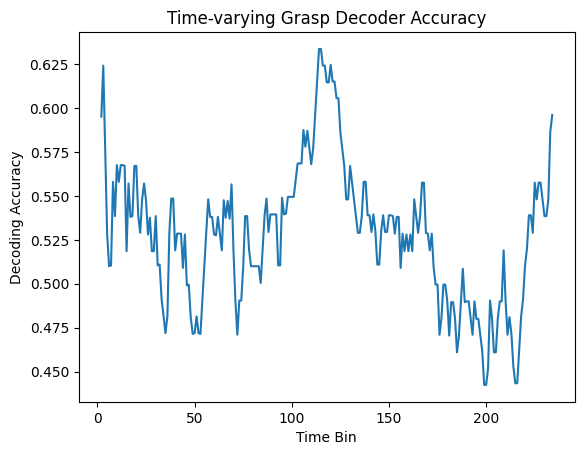

In [ ]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='nb')

# Optional: plot the decoding accuracy over time
import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Plot kinematic target locations

---



# Standard Kalman Filter

---



Format Input (neural data)

In [ ]:
# matrix of neural features for all electrodes over time
X_kf = neural_data


Format Output (kinematic target data) to Include Position & Acceleration

In [ ]:

y_kf = targ


In [ ]:

bin_width = 0.032 # bin width in sec (useful for computing position from velocity data)
targ_pos_binned = targ

from utils import extend_kinematics_from_position

y_kf = extend_kinematics_from_position(targ_pos_binned = targ_pos_binned,
                                       bin_width       = bin_width,
                                       compute         = 'velocity') # velocity


In [ ]:
y_feedback = targ_feedback

Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_kf_train, X_kf_test, y_kf_train, y_kf_test, y_feedback_train, y_feedback_test, = train_test_split(X_kf, y_kf, y_feedback, test_size=0.15, shuffle=False, random_state=42)


### Optimize Kalman Parameters

---



In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # Import tqdm for progress bar

# Define the parameter grid to search
param_grid = {
    'C': np.arange(0.05, 10, 0.05),  # Values for C
    'O': [1]      # Values for O np.arange(1, 5, 1)
}

# Create a list to store results
results = []

# Iterate through the parameter combinations with progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Optimizing Kalman Filter"):
    # Initialize and train the Kalman Filter
    model_kf = KalmanFilter(C=params['C'], O=params['O'])
    model_kf.fit(X_kf_train, y_feedback_train)

    # Make predictions on the test set
    y_pred_kf_test = model_kf.predict(X_kf_test)

    # Calculate R² score
    r2   = r2_score(y_kf_test, y_pred_kf_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_kf_test, y_pred_kf_test, multioutput='raw_values'))

    # Store the results
    results.append({
        'C': params['C'],
        'O': params['O'],
        'R²_fing1': r2[0],
        'R²_fing2': r2[1],
        'R²': np.mean(r2[:2]),
        'RMSE_fing1': rmse[0],
        'RMSE_fing2': rmse[1],
        'RMSE': np.mean(rmse[:2])
    })

# Find the best parameters
best_params = min(results, key=lambda x: x['RMSE'])


Optimizing Kalman Filter: 100%|██████████| 199/199 [03:41<00:00,  1.12s/it]


In [ ]:
# Print parameter tuning results
print("Best parameters:\n")
print("-------------------")
[print(f"{key}: {best_params[key]:.4f}") for key in best_params]


Best parameters:

-------------------
C: 6.5000
O: 1.0000
R²_fing1: 0.1799
R²_fing2: 0.6055
R²: 0.3927
RMSE_fing1: 0.2000
RMSE_fing2: 0.1421
RMSE: 0.1711


[None, None, None, None, None, None, None, None]

In [ ]:
import pandas as pd

tuning_results = pd.DataFrame(results)
tuning_results.sort_values(by='R²', ascending=False, inplace=True)
tuning_results.head(20)
# tuning_results.reset_index(drop=True, inplace=True)

,C,O,R²_fing1,R²_fing2,R²,RMSE_fing1,RMSE_fing2,RMSE
131,6.60,1,0.180175,0.605243,0.392709,0.200011,0.142137,0.171074
132,6.65,1,0.180317,0.605099,0.392708,0.199994,0.142163,0.171078
130,6.55,1,0.180025,0.605376,0.392701,0.200030,0.142113,0.171071
133,6.70,1,0.180450,0.604945,0.392697,0.199978,0.142190,0.171084
129,6.50,1,0.179867,0.605500,0.392683,0.200049,0.142090,0.171070
134,6.75,1,0.180575,0.604781,0.392678,0.199963,0.142220,0.171091
128,6.45,1,0.179699,0.605613,0.392656,0.200069,0.142070,0.171070
135,6.80,1,0.180693,0.604608,0.392650,0.199948,0.142251,0.171100
127,6.40,1,0.179523,0.605715,0.392619,0.200091,0.142052,0.171071
136,6.85,1,0.180802,0.604425,0.392613,0.199935,0.142284,0.171109


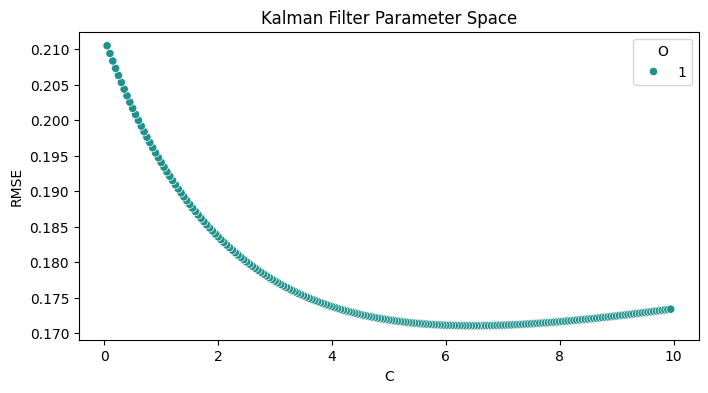

In [ ]:
# tuning_results.plot(x='C', y='RMSE', kind='scatter', hue='O')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.scatterplot(x='C', y='RMSE', hue='O', palette='viridis', data=tuning_results)

# sns.lineplot(x='C', y='R²_fing1', hue='O', palette='viridis', data=tuning_results)
# sns.lineplot(x='C', y='R²_fing2:', hue='O', palette='viridis', data=tuning_results)

plt.title('Kalman Filter Parameter Space')
plt.show()


### Run Kalman Filter

---



In [ ]:
from neural_decoders import KalmanFilter

# Initialize filter
model_kf = KalmanFilter(C=1, O=1) # Kalman filter with precomputed initial state. (Initial state computed during training)
# C controls the smoothing: larger values = more smoothing of the (target) predictions

# Fit model
# model_kf.fit(X_kf_train,y_kf_train)
model_kf.fit(X_kf_train, y_feedback_train, use_PCA_TF=False, PC_thresh=0.8)

y_pred_kf_train = model_kf.predict(X_kf_train)
y_pred_kf_test  = model_kf.predict(X_kf_test)


### Kalman Filter Electrode Weights

---



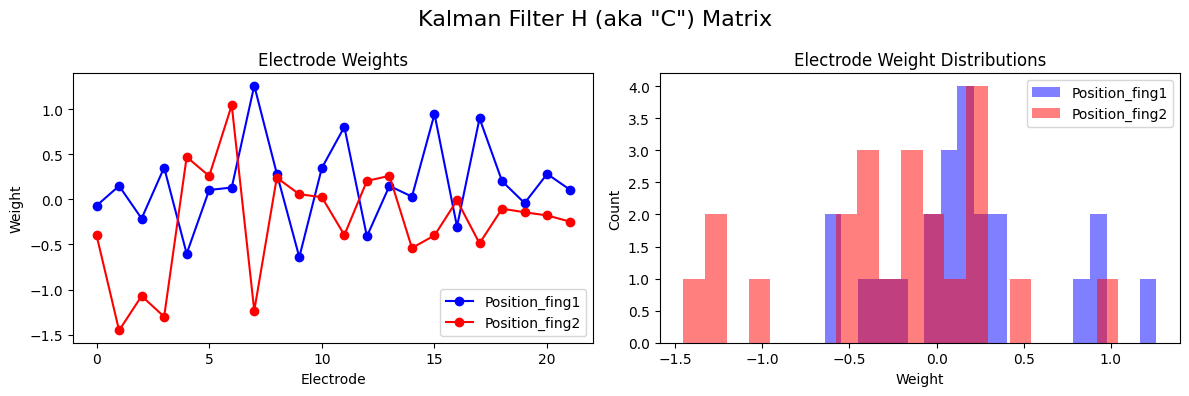

In [ ]:
# H represents the transformation that converts kinematics to neural features
H = model_kf.model['H'] # N x 4 for N electrodes [pos_1, pos_2, vel_1, vel_2]

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].plot(H[:, 0], marker='o', linestyle='-', color='b', label='Position_fing1')
axes[0].plot(H[:, 1], marker='o', linestyle='-', color='r', label='Position_fing2')
axes[0].set_title('Electrode Weights')
axes[0].set_xlabel('Electrode')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(False)

axes[1].hist(H[:, 0], bins=20, color='b', alpha=0.5, label='Position_fing1')
axes[1].hist(H[:, 1], bins=20, color='r', alpha=0.5, label='Position_fing2')
axes[1].set_title('Electrode Weight Distributions')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(False)

plt.suptitle('Kalman Filter H (aka "C") Matrix', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
W_thresh = 0.5
best_chans = np.where((np.abs(H[:, 0]) >= W_thresh) | (np.abs(H[:, 1]) >= W_thresh))[0]
best_chans


array([ 0,  2,  3,  4,  6,  7, 10, 11, 14, 31, 32, 34, 52, 64, 66, 67, 69,
       70, 71, 73, 77, 78, 79, 80, 83])

### Run ReFIT Kalman

---



In [ ]:
# ==== ReFIT Kalman Filter ====
# targets = ground truth target kinematics

# ---- ReFIT Kalman Filter ----
refit_kf = ReFITKalmanFilter(
    C=0.25,
    velocity_rot_method   = "rotate",  # options: "flip", "rotate"
    zero_vel_on_target_TF = True # This parameter doesn't seem too consequential. Just leave it at true
)

# Train using intention-aligned velocities
refit_kf.fit(X_kf_train, y_feedback_train, targets = y_kf_train, targsize=0.075)

# Predict on test neural data
y_pred_kf_train = refit_kf.predict(X_kf_train)
y_pred_kf_test  = refit_kf.predict(X_kf_test)


### Evaluate model performance

---



In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_kf_train, y_pred_kf_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_kf_test, y_pred_kf_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_kf_train, y_pred_kf_train, multioutput='raw_values') # 1 x 6 (pos_1, pos_2, vel_1, vel_2, acc_1, acc_2)
test_r2_list    = r2_score(y_kf_test, y_pred_kf_test, multioutput='raw_values')

from IPython.display import clear_output
# clear_output()

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1681
Train R²: 0.1349
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1673
Test R²: 0.4531


Plot Offline Target Predictions

---



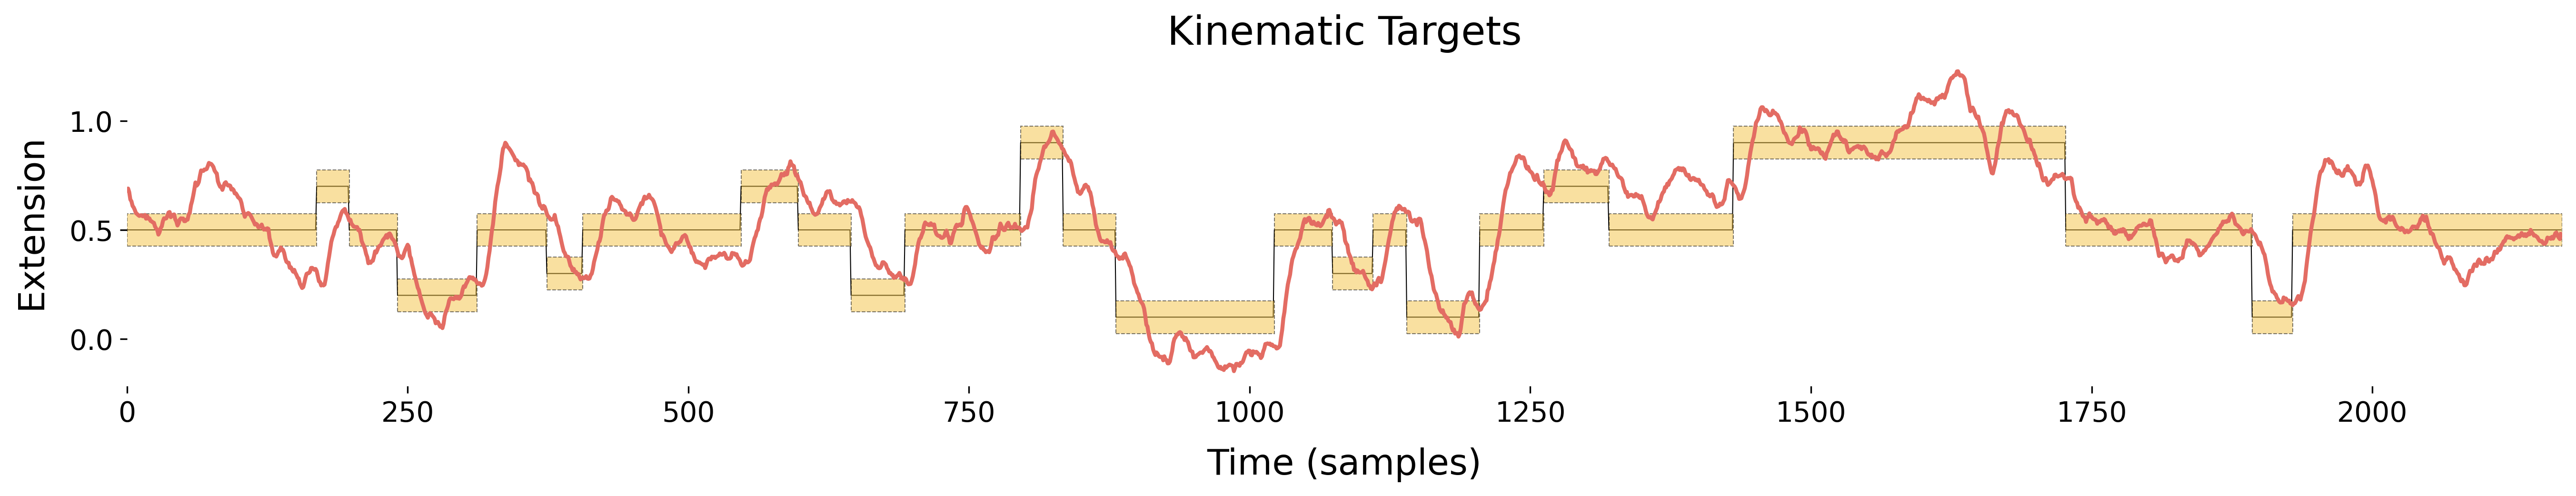


Offline R²: 0.4531


In [ ]:
fing = 1 # select finger to plot
targ_vel      = y_kf_test[:,fing]
targ_vel_pred = y_pred_kf_test[:,fing]
# y_kf_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2, acc_1, acc_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

from utils import plot_targets

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
            #  x_lim        = (0,2000),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


Plot Online Target Predictions

---



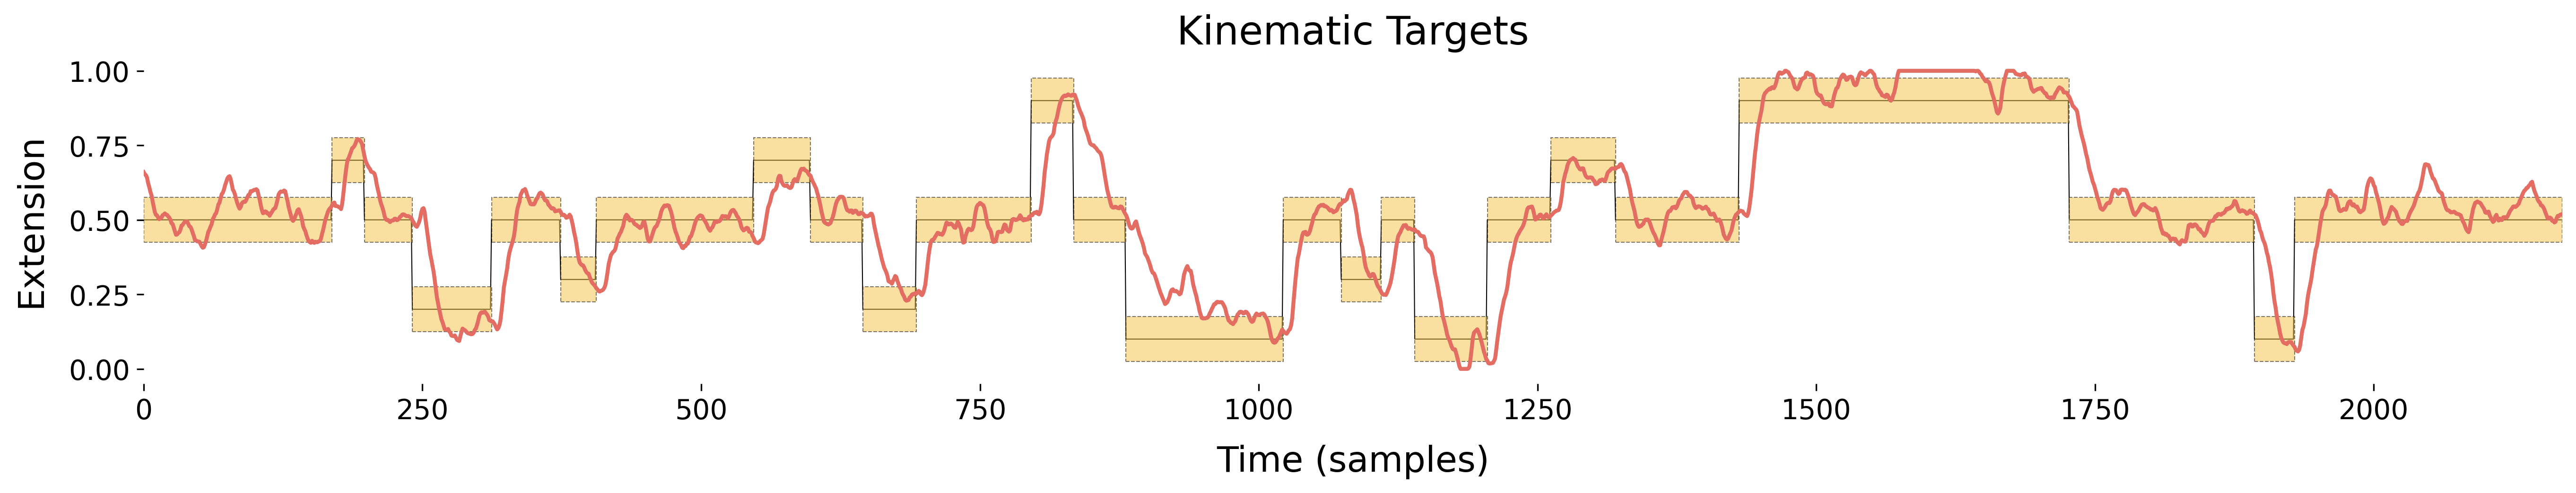


Online R²: 0.6438


In [ ]:
fing = 1 # select finger to plot

targ_vel      = y_kf_test[:,fing]
targ_vel_pred = y_feedback_test[:,fing]
# targ_vel is time_bins x 4 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
            #  x_lim        = (0,2000),
             plot_targ_TF = True)

print(f"\nOnline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# Wiener Filter

---



Prepare data for modeling

In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)


Run Wiener Filter

---



In [ ]:
#Declare model
model_wf = WienerFilterDecoder()

num_bins_before = 5
#Fit model
model_wf.fit(X_train,y_train, num_bins_before = num_bins_before)

# Get predictions
y_pred_train = model_wf.predict(X_train)
y_pred_test  = model_wf.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

# from IPython.display import clear_output
# clear_output()


Evaluate model performance

---



In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1338
Train R²: 0.4517
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1676
Test R²: 0.4524


Plot Offline Target Predictions

---



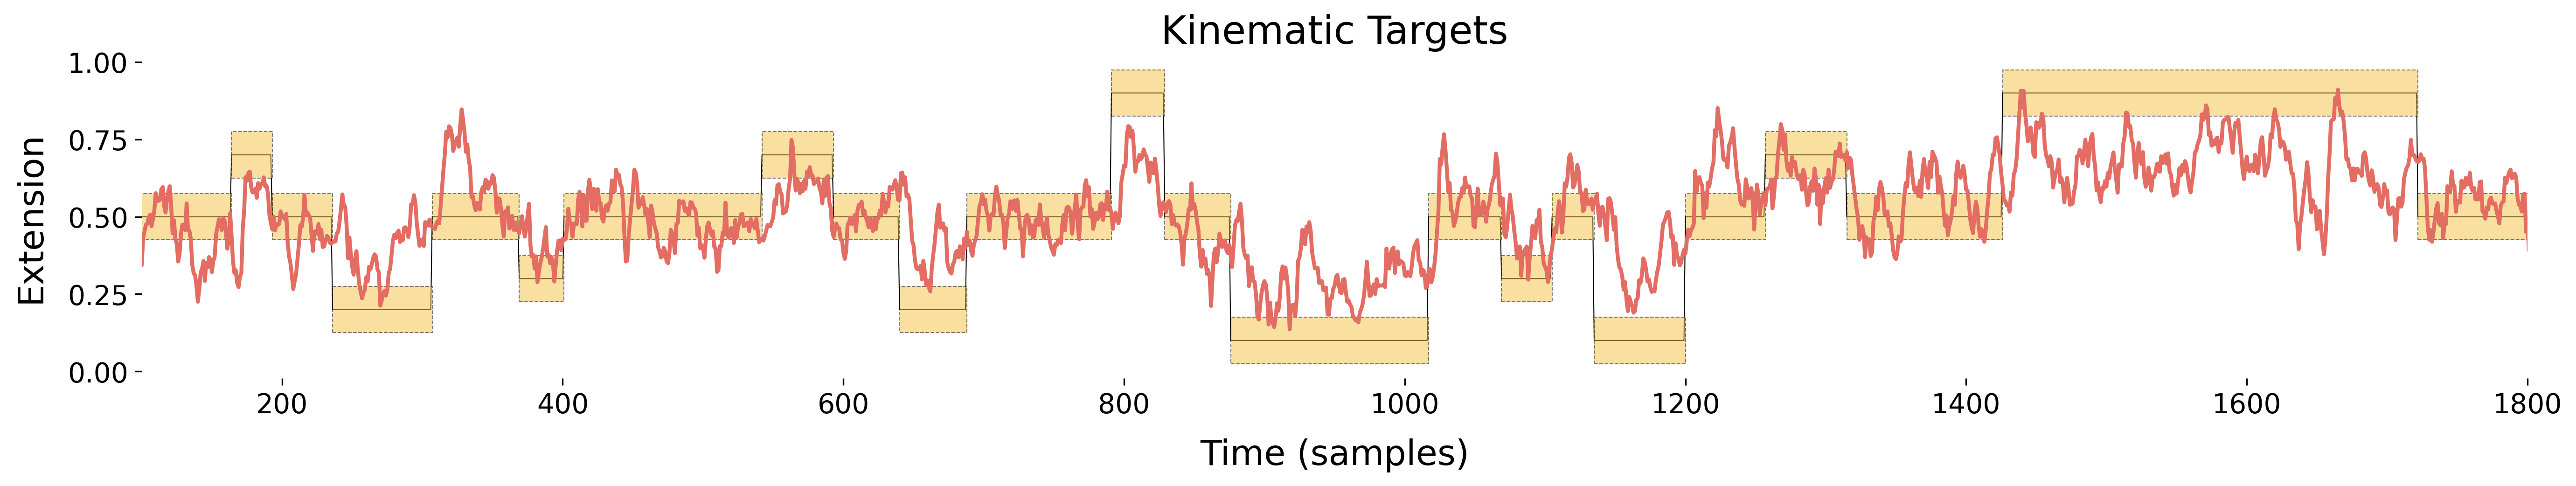


Offline R²: 0.4524


In [ ]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# Ridge Regression Decoder

---



Prepare data for modeling

In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)


Run Ridge Regression Decoder

---



In [ ]:
#Declare model
model_rr = RidgeDecoder(alpha=0.01)

num_bins_before = 10
#Fit model
model_rr.fit(X_train,y_train, num_bins_before = num_bins_before)

# Get predictions
y_pred_train = model_rr.predict(X_train)
y_pred_test  = model_rr.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]


Evaluate model performance

---



In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1236
Train R²: 0.5330
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1603
Test R²: 0.5001


Plot Offline Target Predictions

---



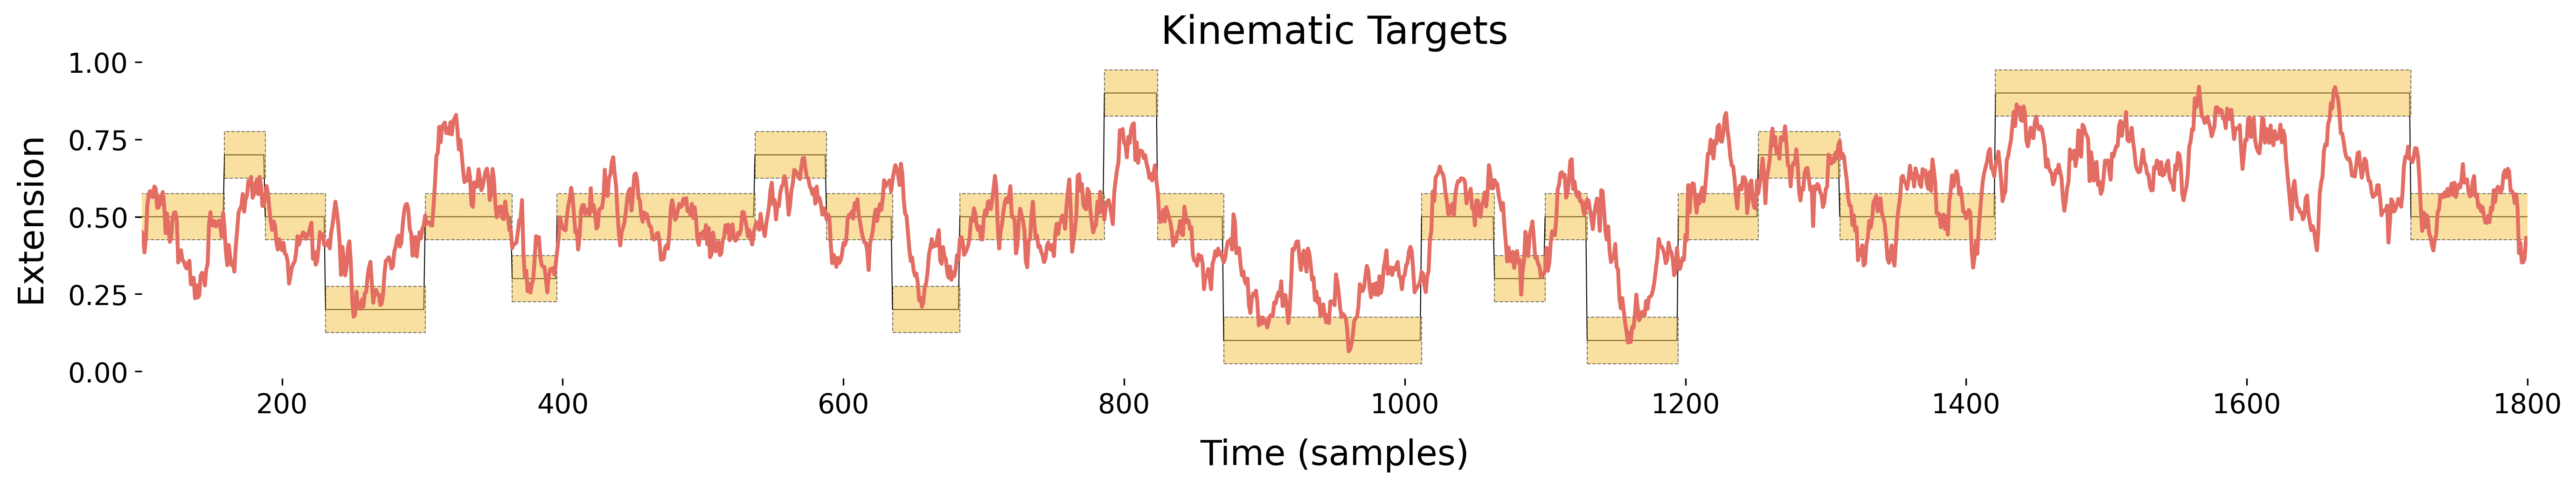


Offline R²: 0.5001


In [ ]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# XGBoost Decoder

---



In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=42)


In [ ]:
# Declare model

num_bins_before = 15
model_xgb = XGBoostMultiOutputDecoder(
    max_depth       = 2,
    eta             = 0.1, # Learning rate
    subsample       = 0.3, # Fraction of samples (rows) randomly selected for training each tree.
    colsample_bytree= 0.1, # Fraction of features (columns) randomly selected for training each tree.
    min_child_weight= 10, # minimum number of instances needed to be in each node.
    num_round       = 500, # Number of boosting rounds
    num_bins_before = num_bins_before,
    patience        = 50,
    val_verbose     = 1
)

model_xgb.fit(X_train, y_train, X_val=X_val, y_val=y_val)

# Get predictions
y_pred_train = model_xgb.predict(X_train)
y_pred_test  = model_xgb.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

from IPython.display import clear_output
clear_output()


Evaluate model performance

---



In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1104
Train R²: 0.6327
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1593
Test R²: 0.5078


Plot Offline Target Predictions

---



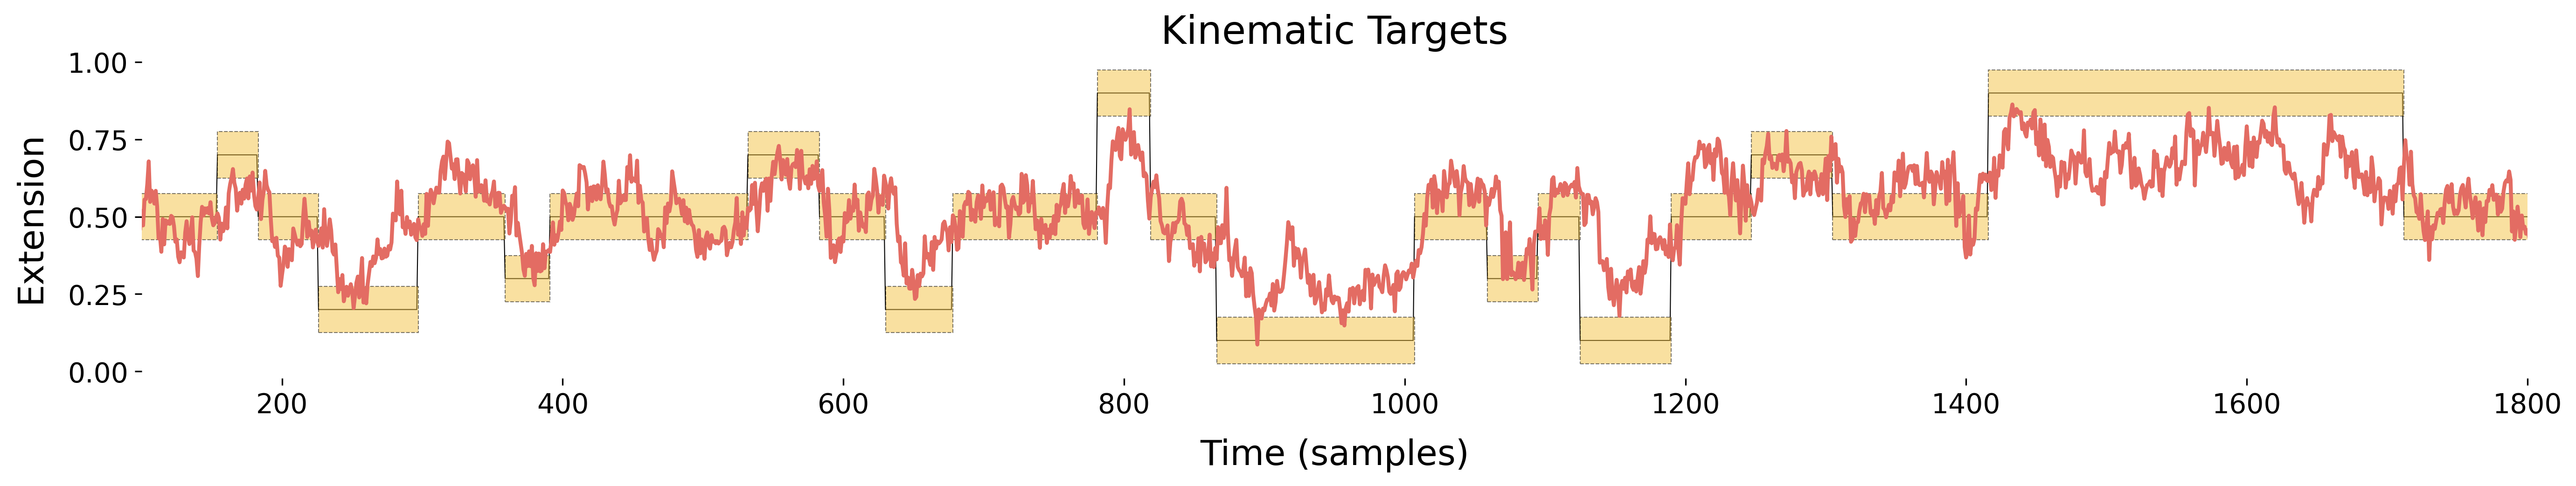


Offline R²: 0.5079


In [ ]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# FeedForward Neural Network

---



In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=42)

In [ ]:
# from neural_decoders import FeedForwardNNDecoder
# from utils import append_history

from neural_decoders import FeedForwardNNDecoder

# Declare model
model_ffn = FeedForwardNNDecoder(units      = 256,
                                 dropout    = 0.5,
                                 batch_size = 512,
                                 num_epochs = 500,
                                 verbose    = 1)

# Fit model
num_bins_before = 10
model_ffn.fit(X_train, y_train,
              val_data = [X_val, y_val],
              early_stopping_TF = True,
              patience = 15,
              num_bins_before = num_bins_before)

# Get predictions
y_pred_train = model_ffn.predict(X_train)
y_pred_test  = model_ffn.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

# from IPython.display import clear_output
# clear_output()


### Evaluate model performance

---



In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1106
Train R²: 0.6306
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1600
Test R²: 0.5020


### Plot Offline Target Predictions

---



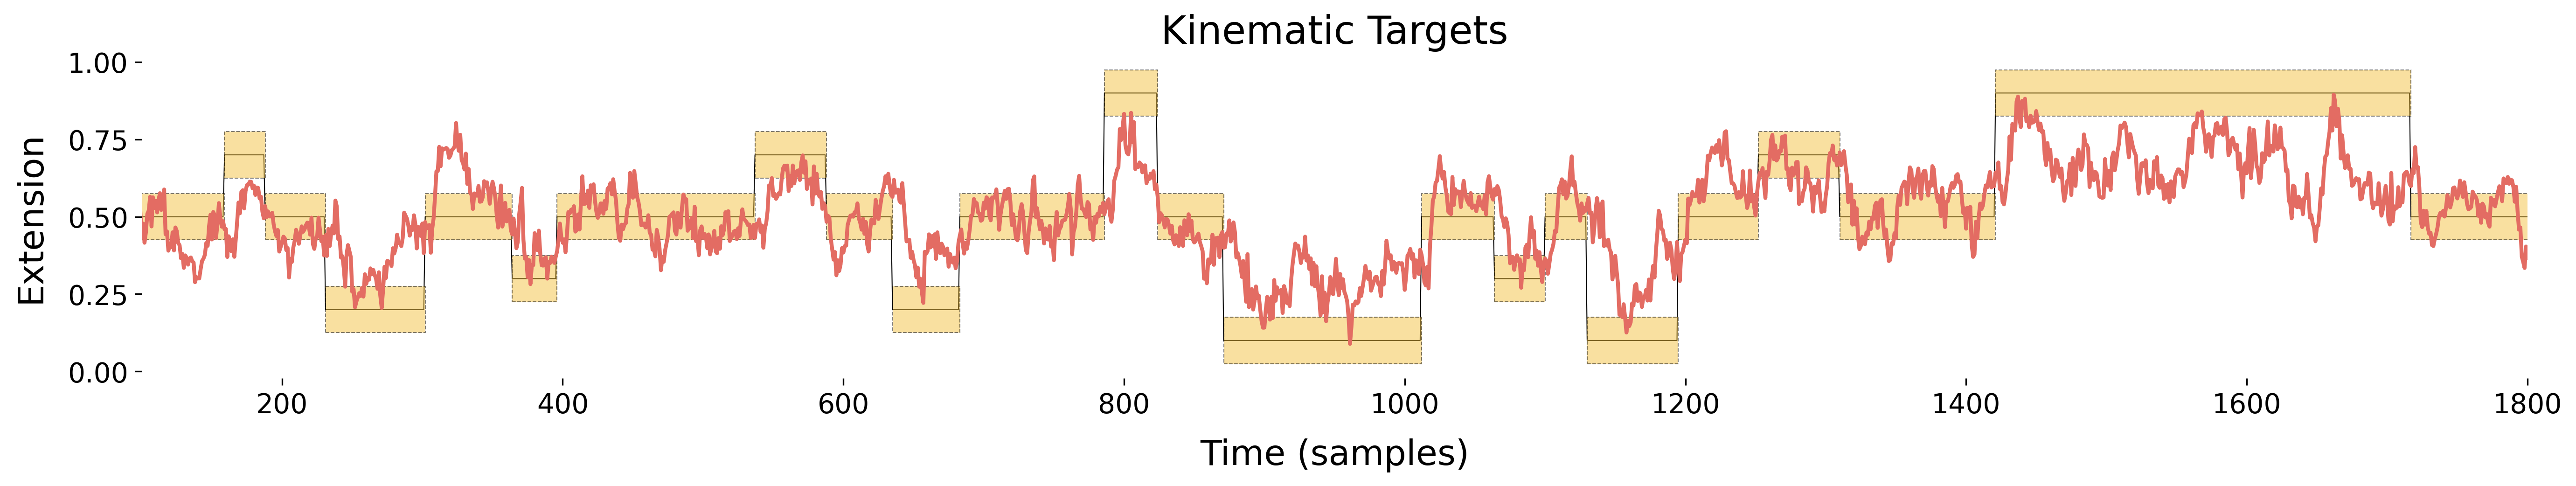


Offline R²: 0.5020


In [ ]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# CNN-FeedForward Hybrid Neural Network

---



In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=42)
print("X_train shape: ", X_train.shape)


X_train shape:  (10446, 96)


### Optimize Hyperparameters

---



In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # Import tqdm for progress bar

# Define the parameter grid to search
param_grid = {
    'learning_rate': np.linspace(0.01, 0.0001, 25),  # np.arange(1, 10, 2)*1e-2, np.logspace(-5,-1,5)
    'dropout_rate': [0.3,0.4],      # np.arange(0.2, 0.6, 0.1)
    'num_bins_before': [15]  # np.arange(3, 15, 3)
}

# Create a list to store results
results = []

# Iterate through the parameter combinations with progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Optimizing CNN-FFNN Architecture"):

    # -----------
    # Declare model
    model_cffn = CNN_FeedForwardNNDecoder(
        hidden_size     = 256,
        ConvSizeOut     = params['num_bins_before'],
        learning_rate   = params['learning_rate'],
        dropout_rate    = params['dropout_rate'],
        num_bins_before = params['num_bins_before']
    )

    # Fit model
    model_cffn.fit(
        X_train, y_train,
        use_PCA_TF      = True,
        PC_thresh       = 10,
        validation_data = (X_val, y_val),
        epochs          = 250,
        batch_size      = 300,
        early_stopping  = True,
        patience        = 10,
        verbose         = 0
    )
    # -----------
    # Make predictions on the test set
    y_pred_test = model_cffn.predict(X_test)

    # Trim y_test to match the length of y_pred_test
    y_test_trimmed = y_test[params['num_bins_before']:] # remove first num_bins_before rows to match prediction data

    # Calculate R² score
    r2   = r2_score(y_test_trimmed, y_pred_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test_trimmed, y_pred_test, multioutput='raw_values'))

    # Plot param values and performance metrics at current iteration
    print(f"\nbins: {params['num_bins_before']}, lr: {params['learning_rate']}, dr: {params['dropout_rate']:.2f} | R²: {np.mean(r2[:2]):.2f}, RMSE: {np.mean(rmse[:2]):.2f}")

    # Store the results
    results.append({
        'num_bins': params['num_bins_before'],
        'learn_rate': params['learning_rate'],
        'dropout': params['dropout_rate'],
        'R²_fing1': r2[0],
        'R²_fing2': r2[1],
        'R²': np.mean(r2[:2]),
        'RMSE_fing1': rmse[0],
        'RMSE_fing2': rmse[1],
        'RMSE': np.mean(rmse[:2])
    })

# Find the best parameters
best_params = max(results, key=lambda x: x['R²'])


Optimizing CNN-FFNN Architecture:   0%|          | 0/50 [00:00<?, ?it/s]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:   2%|▏         | 1/50 [00:29<24:18, 29.77s/it]


bins: 15, lr: 0.01, dr: 0.30 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:   4%|▍         | 2/50 [01:01<24:37, 30.79s/it]


bins: 15, lr: 0.0095875, dr: 0.30 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:   6%|▌         | 3/50 [01:31<24:04, 30.74s/it]


bins: 15, lr: 0.009175, dr: 0.30 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:   8%|▊         | 4/50 [02:01<23:19, 30.41s/it]


bins: 15, lr: 0.0087625, dr: 0.30 | R²: 0.42, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  10%|█         | 5/50 [02:35<23:47, 31.71s/it]


bins: 15, lr: 0.00835, dr: 0.30 | R²: 0.46, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  12%|█▏        | 6/50 [03:06<23:03, 31.44s/it]


bins: 15, lr: 0.0079375, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Optimizing CNN-FFNN Architecture:  14%|█▍        | 7/50 [03:38<22:29, 31.39s/it]


bins: 15, lr: 0.0075250000000000004, dr: 0.30 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  16%|█▌        | 8/50 [04:06<21:22, 30.53s/it]


bins: 15, lr: 0.0071125, dr: 0.30 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  18%|█▊        | 9/50 [04:46<22:47, 33.36s/it]


bins: 15, lr: 0.006699999999999999, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  20%|██        | 10/50 [05:17<21:50, 32.76s/it]


bins: 15, lr: 0.0062875, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  22%|██▏       | 11/50 [05:54<22:08, 34.07s/it]


bins: 15, lr: 0.005875, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  24%|██▍       | 12/50 [06:25<21:00, 33.17s/it]


bins: 15, lr: 0.0054624999999999995, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  26%|██▌       | 13/50 [07:02<21:07, 34.26s/it]


bins: 15, lr: 0.00505, dr: 0.30 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  28%|██▊       | 14/50 [07:36<20:26, 34.07s/it]


bins: 15, lr: 0.004637499999999999, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  30%|███       | 15/50 [08:11<20:03, 34.39s/it]


bins: 15, lr: 0.004225, dr: 0.30 | R²: 0.46, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  32%|███▏      | 16/50 [08:46<19:33, 34.50s/it]


bins: 15, lr: 0.003812499999999999, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  34%|███▍      | 17/50 [09:22<19:14, 34.98s/it]


bins: 15, lr: 0.0033999999999999994, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  36%|███▌      | 18/50 [10:01<19:18, 36.22s/it]


bins: 15, lr: 0.0029874999999999997, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  38%|███▊      | 19/50 [10:43<19:41, 38.10s/it]


bins: 15, lr: 0.002574999999999999, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  40%|████      | 20/50 [11:37<21:23, 42.80s/it]


bins: 15, lr: 0.0021624999999999995, dr: 0.30 | R²: 0.48, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  42%|████▏     | 21/50 [12:18<20:28, 42.35s/it]


bins: 15, lr: 0.0017499999999999998, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  44%|████▍     | 22/50 [13:08<20:44, 44.44s/it]


bins: 15, lr: 0.0013374999999999984, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  46%|████▌     | 23/50 [14:21<23:49, 52.94s/it]


bins: 15, lr: 0.0009249999999999987, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  48%|████▊     | 24/50 [15:28<24:48, 57.25s/it]


bins: 15, lr: 0.0005124999999999991, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  50%|█████     | 25/50 [18:24<38:40, 92.83s/it]


bins: 15, lr: 0.0001, dr: 0.30 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  52%|█████▏    | 26/50 [18:56<29:55, 74.82s/it]


bins: 15, lr: 0.01, dr: 0.40 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  54%|█████▍    | 27/50 [19:25<23:20, 60.91s/it]


bins: 15, lr: 0.0095875, dr: 0.40 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  56%|█████▌    | 28/50 [19:53<18:44, 51.10s/it]


bins: 15, lr: 0.009175, dr: 0.40 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  58%|█████▊    | 29/50 [20:22<15:31, 44.34s/it]


bins: 15, lr: 0.0087625, dr: 0.40 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  60%|██████    | 30/50 [20:50<13:07, 39.39s/it]


bins: 15, lr: 0.00835, dr: 0.40 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  62%|██████▏   | 31/50 [21:19<11:29, 36.28s/it]


bins: 15, lr: 0.0079375, dr: 0.40 | R²: 0.38, RMSE: 0.18
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  64%|██████▍   | 32/50 [22:00<11:21, 37.87s/it]


bins: 15, lr: 0.0075250000000000004, dr: 0.40 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  66%|██████▌   | 33/50 [22:37<10:40, 37.66s/it]


bins: 15, lr: 0.0071125, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  68%|██████▊   | 34/50 [23:09<09:34, 35.93s/it]


bins: 15, lr: 0.006699999999999999, dr: 0.40 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  70%|███████   | 35/50 [23:39<08:31, 34.11s/it]


bins: 15, lr: 0.0062875, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  72%|███████▏  | 36/50 [24:15<08:05, 34.71s/it]


bins: 15, lr: 0.005875, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  74%|███████▍  | 37/50 [24:54<07:48, 36.03s/it]


bins: 15, lr: 0.0054624999999999995, dr: 0.40 | R²: 0.40, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  76%|███████▌  | 38/50 [25:33<07:20, 36.73s/it]


bins: 15, lr: 0.00505, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  78%|███████▊  | 39/50 [26:09<06:43, 36.70s/it]


bins: 15, lr: 0.004637499999999999, dr: 0.40 | R²: 0.46, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  80%|████████  | 40/50 [26:51<06:22, 38.25s/it]


bins: 15, lr: 0.004225, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  82%|████████▏ | 41/50 [27:22<05:25, 36.15s/it]


bins: 15, lr: 0.003812499999999999, dr: 0.40 | R²: 0.42, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  84%|████████▍ | 42/50 [27:59<04:49, 36.20s/it]


bins: 15, lr: 0.0033999999999999994, dr: 0.40 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  86%|████████▌ | 43/50 [28:39<04:21, 37.33s/it]


bins: 15, lr: 0.0029874999999999997, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  88%|████████▊ | 44/50 [29:25<04:00, 40.13s/it]


bins: 15, lr: 0.002574999999999999, dr: 0.40 | R²: 0.42, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Optimizing CNN-FFNN Architecture:  90%|█████████ | 45/50 [30:11<03:29, 41.83s/it]


bins: 15, lr: 0.0021624999999999995, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  92%|█████████▏| 46/50 [31:01<02:57, 44.32s/it]


bins: 15, lr: 0.0017499999999999998, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  94%|█████████▍| 47/50 [32:10<02:35, 51.69s/it]


bins: 15, lr: 0.0013374999999999984, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  96%|█████████▌| 48/50 [33:31<02:00, 60.44s/it]


bins: 15, lr: 0.0009249999999999987, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  98%|█████████▊| 49/50 [34:54<01:07, 67.13s/it]


bins: 15, lr: 0.0005124999999999991, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture: 100%|██████████| 50/50 [37:36<00:00, 45.13s/it]


bins: 15, lr: 0.0001, dr: 0.40 | R²: 0.40, RMSE: 0.17


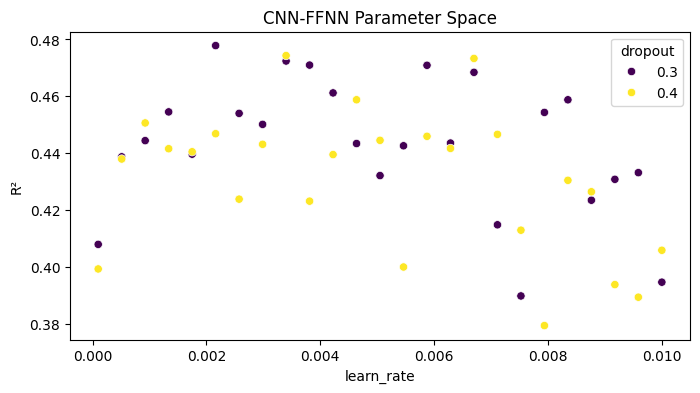

In [ ]:
import pandas as pd
tuning_results = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
# sns.scatterplot(x='learn_rate', y='R²', hue='dropout', style='num_bins', palette='viridis', data=tuning_results)
sns.scatterplot(x='learn_rate', y='R²', hue='dropout', palette='viridis', data=tuning_results)
plt.title('CNN-FFNN Parameter Space')
# plt.xlim(-0.1,0.2)
# plt.xscale('log')
plt.show()


array([0.01  , 0.0089, 0.0078, 0.0067, 0.0056, 0.0045, 0.0034, 0.0023,
       0.0012, 0.0001])

### Fit Model

---



In [ ]:
num_bins_before = 15

from neural_decoders import CNN_FeedForwardNNDecoder
# Declare model
model_cffn = CNN_FeedForwardNNDecoder(
    hidden_size     = 256,
    ConvSizeOut     = num_bins_before,
    learning_rate   = 0.002, # max: 0.01, min: 0.0001, ideal: 0.002
    dropout_rate    = 0.35, # ideal: 0.3
    num_bins_before = num_bins_before
)

# Fit model
model_cffn.fit(
    X_train, y_train,
    use_PCA_TF      = True,
    PC_thresh       = 50,
    validation_data = (X_val, y_val),
    epochs          = 500,
    batch_size      = 512,
    early_stopping  = True,
    patience        = 50
)

# Get predictions
y_pred_train = model_cffn.predict(X_train)
y_pred_test  = model_cffn.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

from IPython.display import clear_output
clear_output()


### Evaluate model performance

---



In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1051
Train R²: 0.6667
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1523
Test R²: 0.5501


### Plot Offline Target Predictions

---



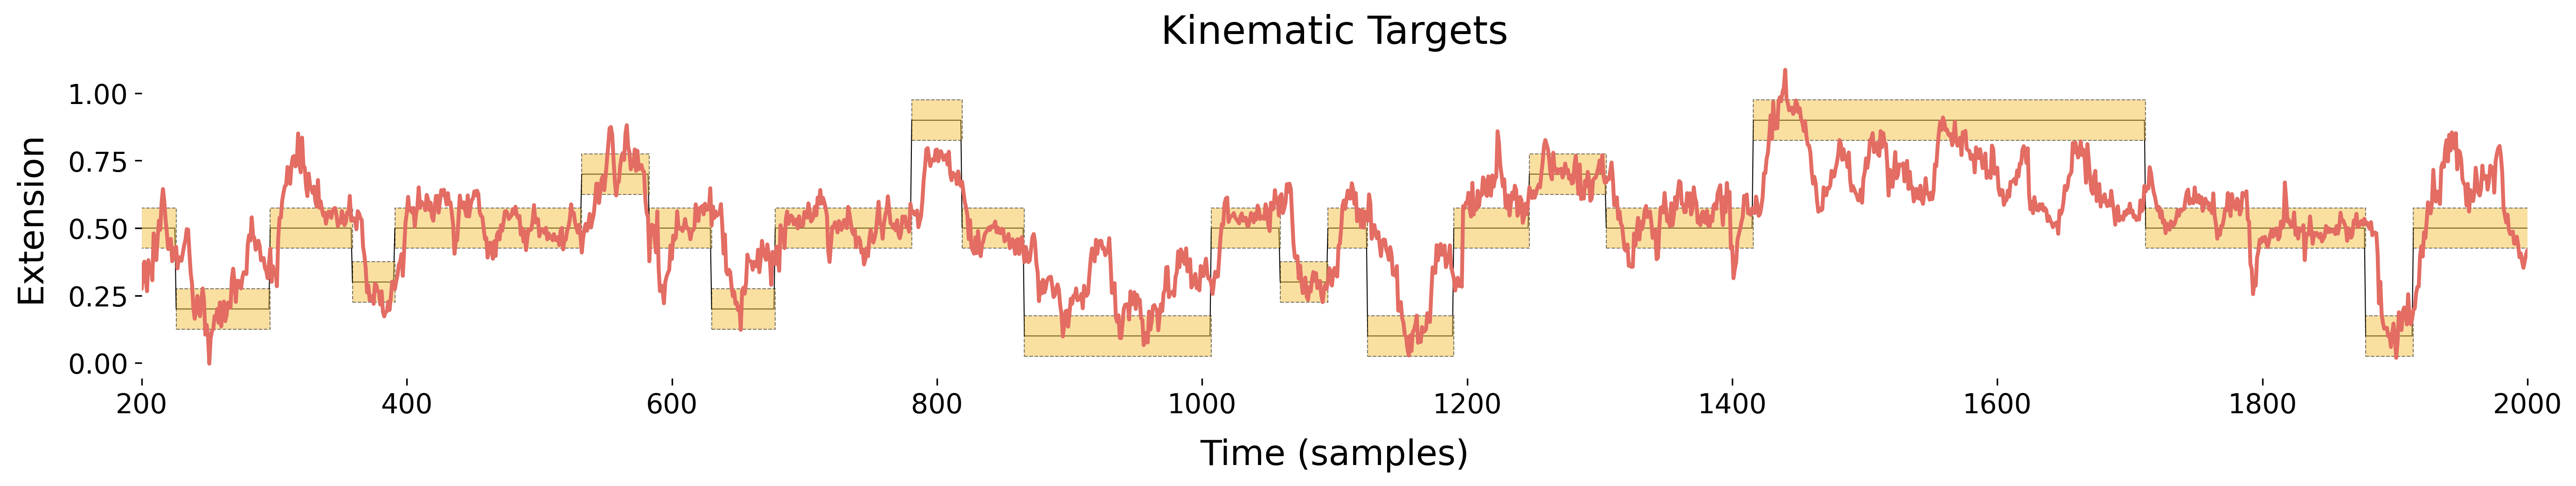


Offline R²: 0.5501


In [ ]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (200,2000),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")
